In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
import os
from collections import Counter
from sklearn.metrics import roc_auc_score as auc
import copy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
import pickle
import warnings
warnings.filterwarnings("ignore")

import TunaSims
import func_ob
import tools
import datasetBuilder
import testUtils
import spectral_similarity

Results for Different Ways of Distributing Interspectral Intensity Difference

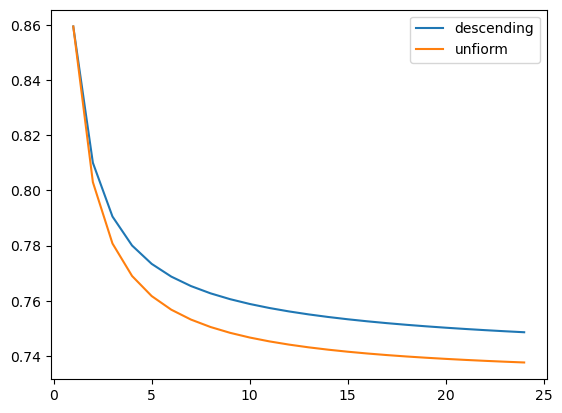

In [2]:
xs=list()
scores_1=list()
scores_2=list()

total_difference = 0.9
len_difference = 10
max_len = 25

func1 = partial(TunaSims.tuna_dif_distance,f=1,g=1,h=2)
func2 = partial(TunaSims.tuna_dif_distance,f=1,g=1,h=2)

normalize = False

for i in range(1,max_len):

    xs.append(i)
    dif_1 = np.array([1/(x+1) for x in range(i)])
    dif_1 = dif_1/sum(dif_1)*total_difference

    dif_2 = np.array([total_difference/i for x in range(i)])

    if normalize:
        scores_1.append(1- 1/func1(dif_1))
        scores_2.append(1 - 1/func2(dif_2))
    else:
        scores_1.append(func1(dif_1, np.zeros(len(dif_1))))
        scores_2.append(func2(dif_2, np.zeros(len(dif_2))))

plt.plot(xs, scores_1, label='descending')
plt.plot(xs, scores_2, label='unfiorm')

plt.legend()
plt.show()

In [3]:
#databases
outputs_path='/Users/jonahpoczobutt/projects/TunaRes/testy'
nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
nist20_prot_deprot = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist20_prot_deprot.pkl'
nist23_hr_prot_deprot_only = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_prot_deprot_only.pkl'
nist23_hr_full ='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_full.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_highres_inst.pkl'
mona_nist = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_nist_prot_only.pkl'

self_search=False
query = metlin
target = nist23_hr_full
if self_search:
    target=query
    
fullRun=True
if fullRun:
    os.mkdir(outputs_path)
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/datasets')

In [4]:
fullRun=True
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    if self_search:
        query_.insert(0,'queryID', [i for i in range(len(query_))])
    else:
        query_.insert(0,'queryID', ["_" for i in range(len(query_))])

    #this method is in place
    np.random.shuffle(all_bases)

    first_bases = all_bases[:int(len(all_bases)*0.5)]
    second_bases = all_bases[int(len(all_bases)*0.5):int(len(all_bases)*0.7)]
    third_bases = all_bases[int(len(all_bases)*0.7):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],second_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    del(second_query_)

    third_query_ = query_[np.isin(query_['inchi_base'],third_bases)]
    third_query_.reset_index(inplace=True)
    third_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    del(third_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/second_bases.npy',second_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/third_bases.npy',third_bases)
    del(first_bases)
    del(second_bases)
    del(third_bases)
    del(all_bases)


In [5]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
reload(datasetBuilder)
reload(tools)

comparison_metrics = ['entropy',
             'manhattan',
             'lorentzian',
             'dot_product',
             'fidelity',
             'matusita',
             'chi2',
             'laplacian',
             'harmonic_mean',
             'bhattacharya_1',
             'squared_chord',
             'cross_ent'
    ]

ppm_windows = [10]
noise_threshes=[0.01,0.0]
centroid_tolerance_vals = [0.05]
centroid_tolerance_types=['da']
powers=['orig',1]
sim_methods=comparison_metrics
prec_removes=[True]
build_dataset=True


train_size=3e6
test_size=1e6
test_size=2e6

max_matches=None
adduct_match = False

target_=pd.read_pickle(target)

if self_search:
    target_.insert(0,'queryID', [i for i in range(len(target_))])
else:
    target_.insert(0,'queryID', ["*" for i in range(len(target_))])

for i in ppm_windows:

    if build_dataset:

        #read in first bases and shuffle order
        query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
        query_train=query_train.sample(frac=1)

        #create matches for model to train on
        matches = datasetBuilder.create_matches_df(query_train,target_,i,max_matches,train_size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/train_matches_{i}_ppm.pkl')
        del(query_train)

        matches_same_ce = matches[matches['ceratio']==1]
        matches_dif_ce = matches[matches['ceratio']!=1]
        
        sub_train_same_ce = datasetBuilder.create_cleaned_df(
                                            matches_same_ce, 
                                            sim_methods, 
                                            noise_threshes, 
                                            centroid_tolerance_vals, 
                                            centroid_tolerance_types,
                                            powers,
                                            prec_removes
        )

        sub_train_dif_ce = datasetBuilder.create_cleaned_df(
                                            matches_dif_ce, 
                                            sim_methods, 
                                            noise_threshes, 
                                            centroid_tolerance_vals, 
                                            centroid_tolerance_types,
                                            powers,
                                            prec_removes
        )

        sub_train_same_ce.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/train_cleaned_matches_same_ce_{i}_ppm.pkl')
        sub_train_dif_ce.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/train_cleaned_matches_dif_ce_{i}_ppm.pkl')

        #read in first bases and shuffle order
        query_val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
        query_query_val = query_val.sample(frac=1)

        #create matches for model to train on
        matches = datasetBuilder.create_matches_df(query_val,target_,i,max_matches,test_size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/val_matches_{i}_ppm.pkl')
        del(query_val)

        
        matches_same_ce = matches[matches['ceratio']==1]
        matches_dif_ce = matches[matches['ceratio']!=1]
        
        sub_val_same_ce = datasetBuilder.create_cleaned_df(
                                            matches_same_ce, 
                                            sim_methods, 
                                            noise_threshes, 
                                            centroid_tolerance_vals, 
                                            centroid_tolerance_types,
                                            powers,
                                            prec_removes
        )

        sub_val_dif_ce = datasetBuilder.create_cleaned_df(
                                            matches_dif_ce, 
                                            sim_methods, 
                                            noise_threshes, 
                                            centroid_tolerance_vals, 
                                            centroid_tolerance_types,
                                            powers,
                                            prec_removes
        )

        sub_val_same_ce.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/val_cleaned_matches_same_ce_{i}_ppm.pkl')
        sub_val_dif_ce.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/val_cleaned_matches_dif_ce_{i}_ppm.pkl')


        #read in first bases and shuffle order
        query_test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
        query_test=query_test.sample(frac=1)

        #create matches for model to train on
        matches = datasetBuilder.create_matches_df(query_test,target_,i,max_matches,test_size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/test_matches_{i}_ppm.pkl')
        del(query_test)

        matches_same_ce = matches[matches['ceratio']==1]
        matches_dif_ce = matches[matches['ceratio']!=1]
        
        sub_test_same_ce = datasetBuilder.create_cleaned_df(
                                            matches_same_ce, 
                                            sim_methods, 
                                            noise_threshes, 
                                            centroid_tolerance_vals, 
                                            centroid_tolerance_types,
                                            powers,
                                            prec_removes
        )

        sub_test_dif_ce = datasetBuilder.create_cleaned_df(
                                            matches_dif_ce, 
                                            sim_methods, 
                                            noise_threshes, 
                                            centroid_tolerance_vals, 
                                            centroid_tolerance_types,
                                            powers,
                                            prec_removes
        )

        sub_test_same_ce.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/test_cleaned_matches_same_ce_{i}_ppm.pkl')
        sub_test_dif_ce.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/test_cleaned_matches_dif_ce_{i}_ppm.pkl')

    else:
        sub_train_same_ce = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/train_cleaned_matches_same_ce_{i}_ppm.pkl')
        sub_val_same_ce = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/val_cleaned_matches_same_ce_{i}_ppm.pkl')
        sub_test_same_ce = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/test_cleaned_matches_same_ce_{i}_ppm.pkl')

        sub_train_dif_ce = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/train_cleaned_matches_dif_ce_{i}_ppm.pkl')
        sub_val_dif_ce = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/val_cleaned_matches_dif_ce_{i}_ppm.pkl')
        sub_test_dif_ce = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/test_cleaned_matches_dif_ce_{i}_ppm.pkl')


100159 rows created
200432 rows created
300737 rows created
400071 rows created
500046 rows created
600044 rows created
700054 rows created
800172 rows created
900207 rows created
1000119 rows created
1100847 rows created
1200149 rows created
1300113 rows created
1400492 rows created
1500470 rows created
1600038 rows created
1700262 rows created
1800190 rows created
1900241 rows created
2000359 rows created
2100012 rows created
2200262 rows created
2300216 rows created
2400337 rows created
2500103 rows created
2600032 rows created
2700202 rows created
2800167 rows created
2900226 rows created
3000011 rows created
total number of query spectra considered: 33926
total number of target spectra considered: 3000011
total inchicores seen: 6591
4982 queries went unmatched
100009 rows created
200587 rows created
300032 rows created
400073 rows created
500360 rows created
600739 rows created
700024 rows created
800610 rows created
900315 rows created
1000153 rows created
1100405 rows created
12

Create Train/Val/Test Data & get Individual Results

In [14]:
reload(testUtils)

train_datasets = [sub_train_same_ce, sub_train_dif_ce]
val_datasets = [sub_val_same_ce, sub_val_dif_ce]
test_datasets = [sub_test_same_ce, sub_test_dif_ce]
dataset_names = ['same_ce','dif_ce']
# train_datasets = [pd.concat((sub_train_same_ce, sub_train_dif_ce)).sample(frac=1)]
# dataset_names=['combined']

gbc_train_datasets = list()
ind_aucs_full = list()

#create init df
for metric in comparison_metrics:
    for j in range(int(train_datasets[0].shape[1]/2)):

        ind_aucs_full.append(f'{metric}_{j}')

ind_aucs_full = pd.DataFrame(ind_aucs_full, columns=['metric'])

for _ in range(len(train_datasets)):

    ind_aucs_=None
    train_data_gbcs = None
    for j in range(int(train_datasets[_].shape[1]/2)):

        sub = train_datasets[_].iloc[:,2*j:2*(j+1)]
        old_cols = sub.columns
        sub.columns=['query','target']
        sub['match'] = train_datasets[_]['match'].tolist()

        ind_aucs, inds = testUtils.orig_metric_to_df(comparison_metrics, sub)
        ind_aucs_ = pd.concat((ind_aucs_, ind_aucs))
        sub = sub.iloc[:,:2]
        sub.columns=old_cols
        train_data_gbcs = pd.concat((train_data_gbcs,inds), axis=1)

    if _ ==0:    
        ind_aucs_full['same_train']=ind_aucs_['AUC'].tolist()
    else:
        ind_aucs_full['dif_train']=ind_aucs_['AUC'].tolist()

    train_data_gbcs['match'] = train_datasets[_]['match'].tolist()
    gbc_train_datasets.append(train_data_gbcs)

with open(f'{outputs_path}/intermediateOutputs/datasets/gbc_train.pkl', 'wb') as handle:

    pickle.dump(gbc_train_datasets, handle)

del(gbc_train_datasets)
print('created train data')

gbc_val_datasets = list()
for _ in range(len(val_datasets)):

    val_data_gbcs = None
    ind_aucs_=None
    for j in range(int(val_datasets[_].shape[1]/2)):

        sub = val_datasets[_].iloc[:,2*j:2*(j+1)]
        old_cols = sub.columns
        sub.columns=['query','target']
        sub['match'] = val_datasets[_]['match'].tolist()

        ind_aucs, inds = testUtils.orig_metric_to_df(comparison_metrics, sub)
        ind_aucs_ = pd.concat((ind_aucs_, ind_aucs))
        sub = sub.iloc[:,:2]
        sub.columns=old_cols
        val_data_gbcs = pd.concat((val_data_gbcs,inds), axis=1)
    
    if _ ==0:    
        ind_aucs_full['same_val']=ind_aucs_['AUC'].tolist()
    else:
        ind_aucs_full['dif_val']=ind_aucs_['AUC'].tolist()

    val_data_gbcs['match'] = val_datasets[_]['match'].tolist()
    gbc_val_datasets.append(val_data_gbcs)

with open(f'{outputs_path}/intermediateOutputs/datasets/gbc_val.pkl', 'wb') as handle:

    pickle.dump(gbc_val_datasets, handle)

del(gbc_val_datasets)
print('created val data')

gbc_test_datasets = list()
for _ in range(len(test_datasets)):

    test_data_gbcs = None
    ind_aucs_ = None
    for j in range(int(test_datasets[_].shape[1]/2)):

        sub = test_datasets[_].iloc[:,2*j:2*(j+1)]
        old_cols = sub.columns
        sub.columns=['query','target']
        sub['match'] = test_datasets[_]['match'].tolist()

        ind_aucs, inds = testUtils.orig_metric_to_df(comparison_metrics, sub)
        ind_aucs['metric'] = [f'{x}_{j}' for x in ind_aucs['metric']]
        ind_aucs_ = pd.concat((ind_aucs_, ind_aucs))
        sub = sub.iloc[:,:2]
        sub.columns=old_cols
        test_data_gbcs = pd.concat((test_data_gbcs,inds), axis=1)
    
    if _ ==0:    
        ind_aucs_full['same_test']=ind_aucs_['AUC'].tolist()
    else:
        ind_aucs_full['dif_test']=ind_aucs_['AUC'].tolist()

    test_data_gbcs['match'] = test_datasets[_]['match'].tolist()
    gbc_test_datasets.append(test_data_gbcs)

with open(f'{outputs_path}/intermediateOutputs/datasets/gbc_test.pkl', 'wb') as handle:

    pickle.dump(gbc_test_datasets, handle)

del(gbc_test_datasets)
print('created test data')

created train data
created val data
created test data


Create indices to pull for each metric and those with same components, specify GBC models

In [17]:
with open(f'{outputs_path}/intermediateOutputs/datasets/gbc_train.pkl', 'rb') as handle:

    gbc_train_datasets = pickle.load(handle)

models = [
                hgbc(),
                hgbc(learning_rate=0.5),
                hgbc(max_iter=200),
                hgbc(learning_rate=0.01,min_samples_leaf=10),
                hgbc(max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
                ]


indices = dict()
indices['all-sims'] = list(range(gbc_train_datasets[0].shape[1]-1))
indices['all-mults'] = list()
indices['all-ents'] = list()
indices['all-difs'] = list()

for i in range(int((gbc_train_datasets[0].shape[1]-1)/len(comparison_metrics))):

    indices[f'setting-{i}-all'] = list(np.array(range(len(comparison_metrics)))+(i*len(comparison_metrics)))
    indices[f'mults-{i}'] = list(np.array([3,4,9])+(i*len(comparison_metrics)))
    indices[f'ents-{i}'] = list(np.array([0,11])+(i*len(comparison_metrics)))
    indices[f'difs-{i}'] = list(np.array([1,2,5,7,10])+(i*len(comparison_metrics)))

    indices[f'all-mults'] = indices['all-mults'] +list(np.array([3,4,9])+(i*len(comparison_metrics)))
    indices[f'all-ents'] =  indices['all-ents'] + list(np.array([0,11])+(i*len(comparison_metrics)))
    indices[f'all-difs'] =  indices['all-difs'] + list(np.array([1,2,5,7,10])+(i*len(comparison_metrics)))


print(f' total number of models for each: {len(models) * len(indices)}')

 total number of models for each: 120


Train Models and Collect Train Error

In [18]:
same_train_model_aucs = list()
model_names = list()
dif_train_model_aucs = list()
trained_models = dict()

for key, value in indices.items():

    sub = gbc_train_datasets[0].iloc[:,value]
    models_ = copy.deepcopy(models)

    for i in range(len(models_)):

        models_[i].fit(sub,gbc_train_datasets[0]['match'])
        pos_ind = np.where(models_[i].classes_==1)[0][0]
        same_train_model_aucs.append(auc(gbc_train_datasets[0]['match'],models_[i].predict_proba(sub)[:,pos_ind]))
        model_names.append(f'{key}_{i}')
        trained_models[f'same_{key}_{i}'] = models_[i]

    sub = gbc_train_datasets[1].iloc[:,value]
    models_ = copy.deepcopy(models)

    for i in range(len(models_)):

        models_[i].fit(sub,gbc_train_datasets[1]['match'])
        pos_ind = np.where(models_[i].classes_==1)[0][0]
        dif_train_model_aucs.append(auc(gbc_train_datasets[1]['match'],models_[i].predict_proba(sub)[:,pos_ind]))
        trained_models[f'dif_{key}_{i}'] = models_[i]

model_aucs = pd.DataFrame([model_names, same_train_model_aucs, dif_train_model_aucs]).transpose()
model_aucs.columns = ['name','same_train','dif_train']

del(gbc_train_datasets)

with open(f'{outputs_path}/intermediateOutputs/datasets/gbc_val.pkl', 'rb') as handle:

    gbc_val_datasets = pickle.load(handle)

same_val = list()
dif_val = list()
same_test = list()
dif_test = list()

for name in model_aucs['name'].tolist():

    subset_name = name.split('_')[0]

    sub = gbc_val_datasets[0].iloc[:,indices[subset_name]]
    model = trained_models[f'same_{name}']
    pos_ind = np.where(model.classes_==1)[0][0]
    same_val.append(auc(gbc_val_datasets[0]['match'],model.predict_proba(sub)[:,pos_ind]))

    sub = gbc_val_datasets[1].iloc[:,indices[subset_name]]
    model = trained_models[f'dif_{name}']
    pos_ind = np.where(model.classes_==1)[0][0]
    dif_val.append(auc(gbc_val_datasets[1]['match'],model.predict_proba(sub)[:,pos_ind]))

del(gbc_val_datasets)

with open(f'{outputs_path}/intermediateOutputs/datasets/gbc_test.pkl', 'rb') as handle:

    gbc_test_datasets = pickle.load(handle)

for name in model_aucs['name'].tolist():

    subset_name = name.split('_')[0]

    sub = gbc_test_datasets[0].iloc[:,indices[subset_name]]
    model = trained_models[f'same_{name}']
    pos_ind = np.where(model.classes_==1)[0][0]
    same_test.append(auc(gbc_test_datasets[0]['match'],model.predict_proba(sub)[:,pos_ind]))

    sub = gbc_test_datasets[1].iloc[:,indices[subset_name]]
    model = trained_models[f'dif_{name}']
    pos_ind = np.where(model.classes_==1)[0][0]
    dif_test.append(auc(gbc_test_datasets[1]['match'],model.predict_proba(sub)[:,pos_ind]))

del(gbc_test_datasets)

model_aucs['same_val'] = same_val
model_aucs['dif_val'] = dif_val
model_aucs['same_test'] = same_test
model_aucs['dif_test'] = dif_test

model_aucs

,name,same_train,dif_train,same_val,dif_val,same_test,dif_test
0,all-sims_0,0.984759,0.846039,0.930347,0.841268,0.934184,0.840837
1,all-sims_1,0.950251,0.84547,0.909765,0.839008,0.908276,0.838968
2,all-sims_2,0.98572,0.8516,0.930927,0.842361,0.936687,0.842271
3,all-sims_3,0.952145,0.834068,0.927028,0.835375,0.933462,0.834810
4,all-sims_4,0.978803,0.850659,0.924058,0.841850,0.932982,0.841526
...,...,...,...,...,...,...,...
115,difs-3_1,0.936389,0.825807,0.906620,0.823774,0.907393,0.822628
116,difs-3_2,0.953043,0.82727,0.919969,0.825342,0.921616,0.824347
117,difs-3_3,0.931622,0.819117,0.917608,0.822174,0.918679,0.820951
118,difs-3_4,0.956681,0.827625,0.920099,0.825335,0.919708,0.824457


Define Distance Functions by Features

In [330]:
flats = {
          'fdif_quadk':(['a','b','c','d','e'],None),
          'fadd_quadk':(['f','g','h','i','j'],None),
          'fmult_quadk':(['k','l','m','n','o'],None),
}

exts = {'edif_add':(['b','g','p','q','r','s','t','u','v','w'],None),
        'edif_mult':(['b','l','x','y','z','a_','b_','c_','d_','e_'],None),
        'emult_add':(['l','g','f_','g_','h_','i_','j_','k_','l_','m_'],None),      
}

params = dict()
seen =set()
for key in flats.keys():
    for key_ in flats.keys():

        feature_type = key.split('_')[0]
        feature_type_ = key_.split('_')[0]

        func_type = key.split('_')[1]
        func_type_ = key_.split('_')[1]

        try:
            bounds_type = key.split('_')[2]
            bounds_type_ = key_.split('_')[2]
        except:
            bounds_type = ''
            bounds_type_ = ''


        params[f'{key}_{key_}']=(sorted(list(set(flats[key][0]+flats[key_][0]))),testUtils.dict_combine(flats[key][1],flats[key_][1]))
        
params_ = dict()
seen =set()
for key in exts.keys():
    for key_ in exts.keys():

        feature_type = key.split('_')[0]
        feature_type_ = key_.split('_')[0]

        func_type = key.split('_')[1]
        func_type_ = key_.split('_')[1]

        try:
            bounds_type = key.split('_')[2]
            bounds_type_ = key_.split('_')[2]
        except:
            bounds_type = ''
            bounds_type_ = ''


        params_[f'{key}_{key_}']=(sorted(list(set(exts[key][0]+exts[key_][0]))),testUtils.dict_combine(exts[key][1],exts[key_][1]))

params.update(params_)   

params['all_flat_quadk']= (['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o'],None)
params['all_ext_quadk'] = (['b','l','g','p','q','r','s','t','u','v','w','x','y','z','a_','b_','c_','d_','e_','f_','g_','h_','i_','j_','k_','l_','m_'],None)

for key in params_.keys():
    params[f'{key}_normed']=(sorted(list(set(params_[key][0]+['n_','o_','p_','q_','r_','s_']))),testUtils.dict_combine(params_[key][1],None))

params['norm_only']=(['n_','o_','p_','q_','r_','s_'],None)

In [331]:
flats = {
          'fdif_quad':(['a','b','c'],None),
          'fadd_quad':(['f','g','h'],None),
          'fmult_quad':(['k','l','m'],None),
}

exts = {'edif_add_quad':(['b','g','p','q','r','s','t','u'],None),
        'edif_mult_quad':(['b','l','x','y','z','a_','b_','c_'],None),
        'emult_add_quad':(['l','g','f_','g_','h_','i_','j_','k_'],None),      
}

params2 = dict()
seen =set()
for key in flats.keys():
    for key_ in flats.keys():

        feature_type = key.split('_')[0]
        feature_type_ = key_.split('_')[0]

        func_type = key.split('_')[1]
        func_type_ = key_.split('_')[1]

        try:
            bounds_type = key.split('_')[2]
            bounds_type_ = key_.split('_')[2]
        except:
            bounds_type = ''
            bounds_type_ = ''


        params2[f'{key}_{key_}']=(sorted(list(set(flats[key][0]+flats[key_][0]))),testUtils.dict_combine(flats[key][1],flats[key_][1]))
        
params2_ = dict()
seen =set()
for key in exts.keys():
    for key_ in exts.keys():

        feature_type = key.split('_')[0]
        feature_type_ = key_.split('_')[0]

        func_type = key.split('_')[1]
        func_type_ = key_.split('_')[1]

        try:
            bounds_type = key.split('_')[2]
            bounds_type_ = key_.split('_')[2]
        except:
            bounds_type = ''
            bounds_type_ = ''


        params2_[f'{key}_{key_}']=(sorted(list(set(exts[key][0]+exts[key_][0]))),testUtils.dict_combine(exts[key][1],exts[key_][1]))

params2['all_flat_quad']= (['a','b','c','f','g','h','k','l','m'],None)
params2['all_ext_quad'] = (['b','l','g','p','q','r','s','t','u','x','y','z','a_','b_','c_','f_','g_','h_','i_','j_','k_'],None)


for key in params2_.keys():
    params2[f'{key}_normed']=(sorted(list(set(params2_[key][0]+['n_','o_','p_','s_']))),testUtils.dict_combine(params2_[key][1],None))

params2.update(params2_) 
params.update(params2)  


Create all Func Obs

In [332]:
reload(func_ob)
reload(TunaSims)
reload(testUtils)
#helper lambda funcs
squared_loss = lambda x: (1-x)**2
lin_loss = lambda x: np.abs(1-x)
l1_reg = lambda l,x: l*np.sum(np.abs(x))
l2_reg = lambda l,x: l*np.sqrt(np.sum(x**2))
no_reg = lambda x: 0

reg_funcs = [no_reg,partial(l2_reg,l=0.01)]
reg_names = ['none_none','l2_0.01','l2_0.1']
losses = [squared_loss]
loss_names = ['squared']
momentums = ['none']
mom_weights = [[0.2,0.8]]
lambdas = [0.01]
max_iters = [1e5]

funcs_same = testUtils.create_all_funcs_stoch(reg_funcs=reg_funcs,
                                       reg_names=reg_names,
                                       losses=losses,
                                       loss_names=loss_names,
                                       momentums=momentums,
                                       params=params,
                                       mom_weights=mom_weights,
                                       lambdas=lambdas,
                                       max_iters=max_iters,
                                       func = TunaSims.tuna_combo_distance)

funcs_dif = testUtils.create_all_funcs_stoch(reg_funcs=reg_funcs,
                                       reg_names=reg_names,
                                       losses=losses,
                                       loss_names=loss_names,
                                       momentums=momentums,
                                       params=params,
                                       mom_weights=mom_weights,
                                       lambdas=lambdas,
                                       max_iters=max_iters,
                                       func = TunaSims.tuna_combo_distance)

all_funcs = [funcs_same, funcs_dif]

print(f'number of specifications: {len(funcs_same)}')

number of specifications: 118


In [333]:
trained_dict = dict()

for _ in range(len(train_datasets)):
    
    for j in range(int(train_datasets[_].shape[1]/2)):

        sub = train_datasets[_].iloc[:,2*j:2*(j+1)]
        sub.columns=['query','target']
        sub['match'] = train_datasets[_]['match']
    
        trained=list()
        for i in range(len(all_funcs[_])):
            
            all_funcs[_][i].fit(sub)
            trained.append(all_funcs[_][i])
            if i+1%10==0:
                print(f'trained {i} functions on {dataset_names[_]}_{j}')


        trained_dict[f'{dataset_names[_]}_{j}'] = trained

Get AUCs

In [ ]:
test_datasets = [sub_test_same_ce, sub_test_dif_ce]
#test_datasets = [pd.concat((sub_train_same_ce, sub_train_dif_ce)).sample(frac=1)]
reload(func_ob)
reload(TunaSims)
reload(testUtils)

trained_res=None
for _ in range(len(train_datasets)):
    for j in range(int(train_datasets[_].shape[1]/2)):

        #grab trained models for this portion of dataframe
        models = trained_dict[f'{dataset_names[_]}_{j}']
        sub = train_datasets[_].iloc[:,2*j:2*(j+1)]
        sub.columns=['query','target']
        sub['match'] = train_datasets[_]['match'].tolist()

        small = testUtils.trained_res_to_df(models,sub)
        small.insert(1,'settings', f'{dataset_names[_]}_{j}')
        trained_res=pd.concat((trained_res,small))

print('generated train results')

val_aucs=list()
for _ in range(len(val_datasets)):
    for j in range(int(val_datasets[_].shape[1]/2)):

        #grab trained models for this portion of dataframe
        models = trained_dict[f'{dataset_names[_]}_{j}']
        sub = val_datasets[_].iloc[:,2*j:2*(j+1)]
        sub.columns=['query','target']
        sub['match'] = val_datasets[_]['match'].tolist()
        val_aucs = val_aucs + testUtils.trained_res_to_df(models,sub)['AUC'].tolist()

trained_res['val']=val_aucs
print('generated val results')

test_aucs=list()
for _ in range(len(test_datasets)):
    for j in range(int(test_datasets[_].shape[1]/2)):

        #grab trained models for this portion of dataframe
        models = trained_dict[f'{dataset_names[_]}_{j}']
        sub = test_datasets[_].iloc[:,2*j:2*(j+1)]
        sub.columns=['query','target']
        sub['match'] = test_datasets[_]['match'].tolist()
        test_aucs = test_aucs + testUtils.trained_res_to_df(models,sub)['AUC'].tolist()

trained_res['test']=test_aucs
print('generated test results')



KeyboardInterrupt: 

Conclusions: 

add offsets for terms

num of params not appearing to change train time much

consider replacing knockouts with sigmoids

consider tuning final sigmoid

should features like length,entropy be included in the similarity, or be used outside as extra feature in learned mod.both? neither?


Other Ideas:

Accuracy (In order of increasing difficulty):

-Incorporate as feature how many possible chem structures (can also restrict to NPS) exist within a certain precursor distance. (violating golden rules or not)

-include original NIST version or theoretical res as feature

-Weight different ranges of spec differently for matches (more diversity/greater accuracy)

-smush together top n results over different inchicores and come up with combined model predicting over individual inchicores

-diagnostic ion/loss classing as a feature...do they match

-kernelized smooth match

-3d struct guesses...do they match (cores, but can generalize to 3d)

Speed(In order of increasing difficulty):

-combine sim metrics and expand(apply func to df)

-exclude matches based on non-similarity features to cut down on needed comparisons

-ion tables to upper bound similarity

-only use one peak consolidation and matching protocol...then only do reweight transformations on already matched peaks for spec and sim features

-can missing peaks in lower energy be explained by frags and losses from higher energy? incorporate into model

Order to proceed:

-recreate databases with coll energy included (standardized format across DBs)

-what proportion of matches are the same coll energy?

-quantify variability in peak appearance vs peak intensity across collision energies
    -does this relate in a predictable way to fragment mass

-test sim metrics for same coll energy vs not same col energy (is the same inductive bias useful)

-Show that regular funcs are in the space of combo distance

-test combining individual metrics that use different components of the 2 vectors (add, mult, dif)

-range over individual metrics in combined score in attempt to explain why combining them is successful

-train combo metrics with flattened components and individual (should these sims be broken out?)
    -should we do this for same coll energy vs dif energies

-are different combo metrics put into larger model more successful than the combined individual metrics

-can tunasims be fit with nonlinearities between the components (flattened or not?)